# Gaussian Process Regression

In [1]:
import matplotlib.pyplot as plt # Plotting package
from mpl_toolkits.mplot3d import Axes3D # 3D plotting package
import numpy as np # Fast array-based computations
import pandas as pd # Data manipulation package
from scipy import stats # Used for drawing from stats distributions
import seaborn as sn # Used for more pretty plotting (but not really necessary)

In [2]:
%matplotlib notebook
plt.style.use('seaborn')

In [3]:
import numpy as np
from scipy.linalg import solve_triangular

class GPR:
    """Gaussian Process regressors can be instantiated and sampled from
    using this class. The code is based on Algorithm 2.1 from Rasmussen 
    and Williams' Gaussian process regression book.
    """
    def __init__(self, kernel=None, noise_level=0.00005):
        """Must provide the kernel function and a noise_level. The kernel
        function should take two inputs and return a covariance matrix 
        between those inputs. The noise_level describes how noisy we think 
        the input data is. A noise level of 0 will cause the GP to exactly 
        interpolate the data points, unless you account for the noise in
        your kernel function.
        """
        # Use the default kernel if not provided.
        if kernel is None: kernel = self.rbf_kernel   

        self.kernel = kernel
        self.noise_level = noise_level
    
    
    @staticmethod
    def rbf_kernel(x1,x2,sig=1.0):
        """The RBF kernel (squared exponential distance)."""
        sqdist = np.linalg.norm(x1[:,np.newaxis] - x2, axis=-1)**2
        return np.exp( -sqdist / (2*sig**2))

    
    def fit(self, X, y):
        """Trains the Gaussian process by finding the internal parameters K, 
        L.
        """
        # Take the output mean so we can normalize our GP's output.
        self.mu_hat = y.mean()
        
        self.X = X
        self.y = y - self.mu_hat # Now the y's have sample mean 0.
        K = self.kernel(X, X)
        self.L = np.linalg.cholesky(K + self.noise_level*np.eye(len(X)))
        temp = solve_triangular(self.L, self.y, lower=True)
        self.alpha = solve_triangular(self.L.T, temp)
        
        
    def predict(self, x_star, return_std=False):
        """Returns the mean of the GP at x_star. Can also return the standard
        deviation at each of those points if desired. Note that the standard
        deviation calculations are the most performance-intensive aspect
        of this function.
        """        
        # Compute the mean at the test points.
        k_star = self.kernel(self.X, x_star)
        mu = k_star.T @ self.alpha
        mu += self.mu_hat # So that the output has the correct sample mean.
        
        # Compute the standard deviation.
        if return_std:
            v = solve_triangular(self.L, k_star, lower=True)
            # We take np.diag in the following line to discard covariances.
            std = np.sqrt(np.diag(self.kernel(x_star, x_star) - v.T @ v))
            return mu, std
        
        return mu
    
    
    def llh(self):
        """Returns the log-likelihood of the trained GPR."""
        llh = -0.5*self.y.T @ self.alpha 
        llh -= np.sum(np.log(np.diag(self.L))) 
        llh -= len(self.L)/2*np.log(2*np.pi)
        return llh
    

# Create the multiclass model
class multid_GPR:
    def __init__(self, gprs):
        """Initialize a list of gprs."""
        self.gprs = gprs
    
    def predict(self, X, return_std=False):
        
        out = []
        for gpr in self.gprs:
            out.append(gpr.predict(X,return_std=False))
        
        return np.array(out)

### Constructing a Model

First, we must find a model whose sensitivity we care about. 
Ideally, this model will be nonlinear, but not take too much time to find solutions to. 
For this example, the model we will use is a Gaussian process regressor that models parameters of an underwater fault line.
The model takes two inputs: latitude and longitude. 
It outputs 3 desired quantities: depth, strike, and dip.
Depth represents the depth of the seafloor below sea level, and strike and dip are angles that describe the geometry of the fault.

In [5]:
import cartopy # Mapping package
import cartopy.crs as ccrs

# TsunamiBayes is a package we've created in my research.
# It utilizes Bayesian methods to predict past Tsunamis based on historical data.
import tsunamibayes as tb
from tsunamibayes.fault import ReferenceCurveFault, BaseFault
from tsunamibayes.multifault import MultiFault
from tsunamibayes.utils import bearing, haversine

In [8]:
from sensitivity_data_loader import load_data

lats, lons, depths, dips, strikes, rakes = load_data()

Save the Flores data to a file

In [11]:
np.savez('flores_data', lats=lats, lons=lons, depths=depths, dips=dips, strikes=strikes, rakes=rakes)

#### Fit a Gaussian Process to Our Data

In [7]:
# Get data for plotting
plotting_lats = np.linspace(-9, -8, 100)
plotting_lons = np.linspace(115, 127, 100)
Xplot, Yplot = np.meshgrid(plotting_lons,plotting_lats)

<IPython.core.display.Javascript object>


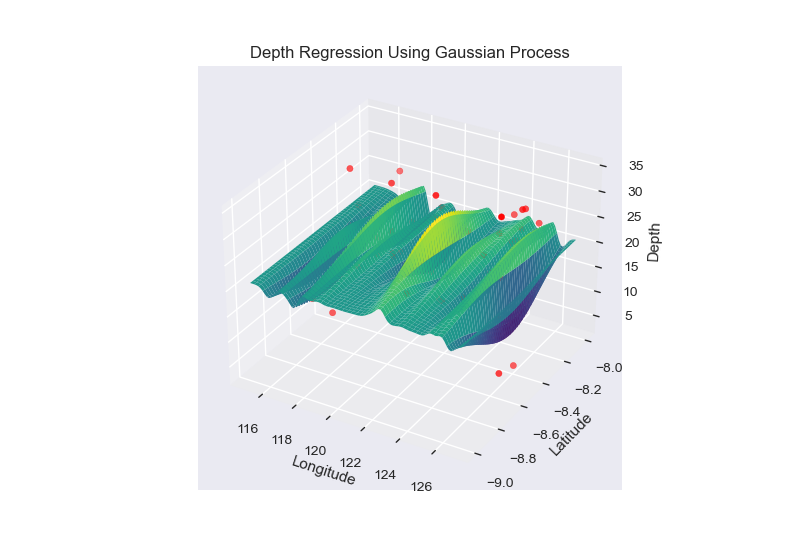

In [86]:
# Get data for fitting the GP
X = np.vstack([lats, lons]).T
y = depths.copy()
ker = lambda x,y: GPR.rbf_kernel(x,y,sig=0.25)
depth_gpr = GPR(kernel=ker, noise_level=1.0)

# Fit to data using Maximum Likelihood Estimation of the parameters
depth_gpr.fit(X, y)
Zplot,sigma = depth_gpr.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T, return_std=True)
Zplot = Zplot.reshape(Xplot.shape)
#sigma = sigma.reshape(Xplot.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='viridis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude'),
ax.set_zlabel('Depth')
plt.title('Depth Regression Using Gaussian Process')
plt.show()

<IPython.core.display.Javascript object>


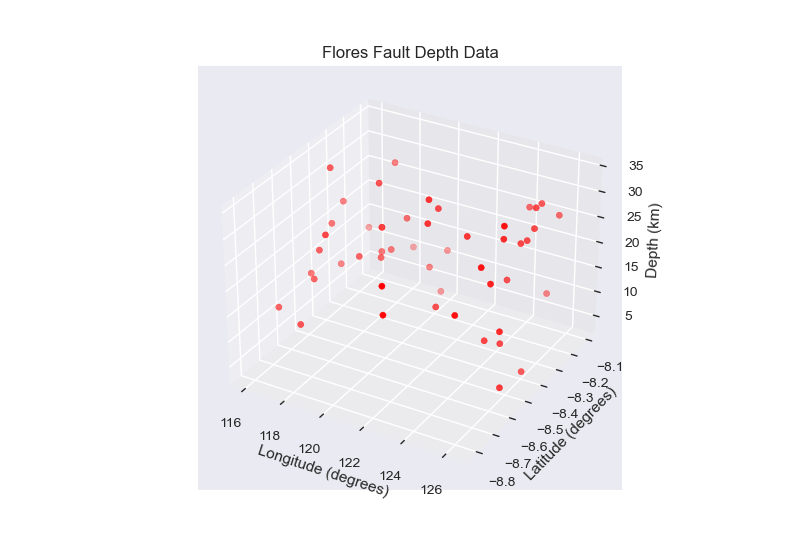

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
#ax.plot_surface(Xplot,Yplot,Zplot,cmap='viridis')
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)'),
ax.set_zlabel('Depth (km)')
plt.title('Flores Fault Depth Data')
plt.show()

<IPython.core.display.Javascript object>


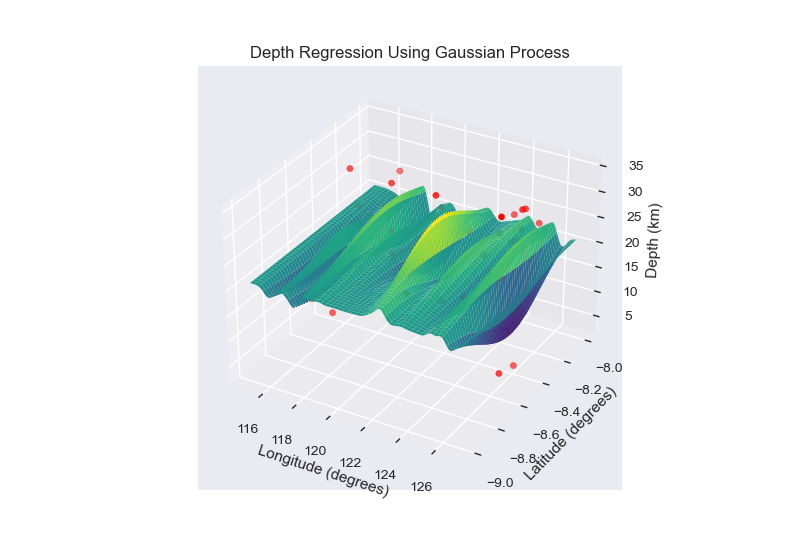

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='viridis')
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)'),
ax.set_zlabel('Depth (km)')
plt.title('Depth Regression Using Gaussian Process')
plt.show()

<IPython.core.display.Javascript object>


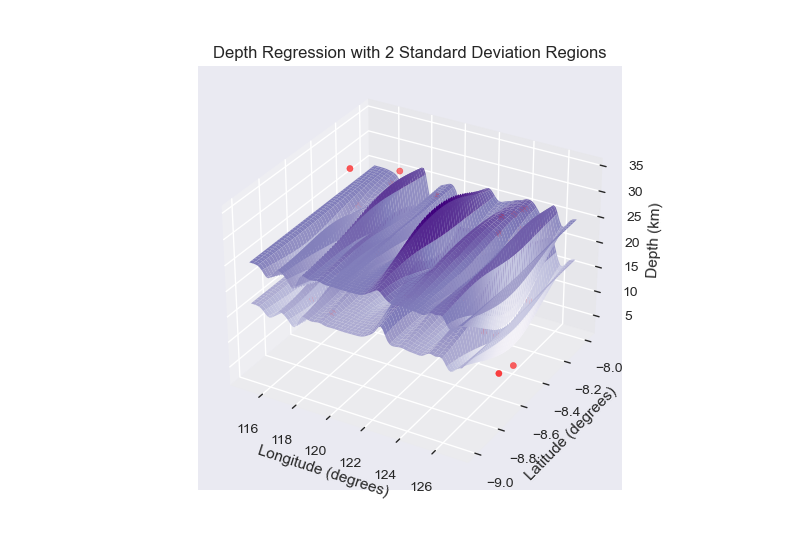

In [89]:
sigma = sigma.reshape(Xplot.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
#ax.plot_surface(Xplot,Yplot,Zplot,cmap='viridis')
ax.plot_surface(Xplot,Yplot,Zplot+4*sigma, cmap='Purples')
ax.plot_surface(Xplot,Yplot,Zplot-4*sigma, cmap='Purples')
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)'),
ax.set_zlabel('Depth (km)')
plt.title('Depth Regression with 2 Standard Deviation Regions')
plt.show()

<IPython.core.display.Javascript object>


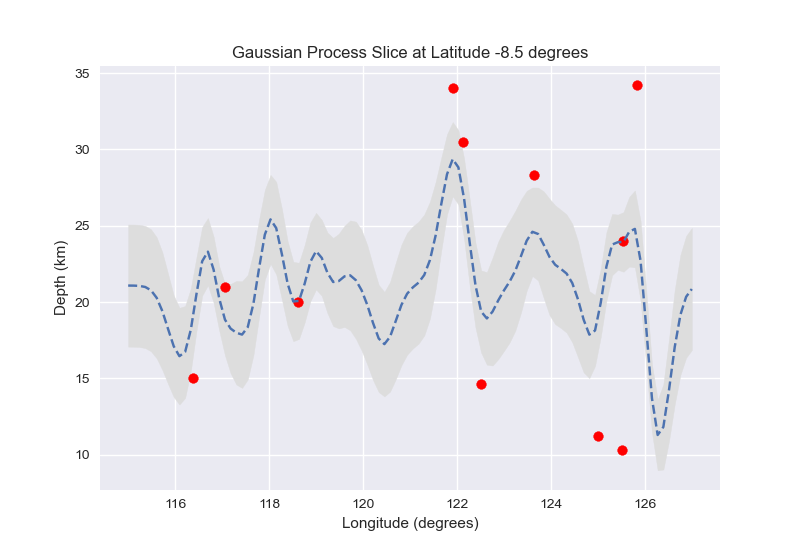

Text(0, 0.5, 'Depth (km)')

In [91]:
plt.figure()
plt.plot(Xplot[50],Zplot[50],'--')
plt.gca().fill_between(
    Xplot[50], 
    Zplot[50]-4*sigma[50], 
    Zplot[50]+4*sigma[50], 
    color="#dddddd"
)
mask = np.abs(X[:,0] - Yplot[50][0]) < 0.05
plt.scatter(X[:,1][mask], y[mask],c='r')
plt.title('Gaussian Process Slice at Latitude -8.5 degrees')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Depth (km)')

In [73]:

X[:,0][mask]
X[:,1]

array([-8.48888889, -8.54166667, -8.475     , -8.50555556, -8.49444444,
       -8.51944444, -8.54166667, -8.44722222, -8.49722222, -8.46666667,
       -8.50277778])

array([125.5       , 125.225     , 125.45555556, 125.13611111,
       122.5       , 121.73888889, 120.38611111, 119.25833333,
       119.05277778, 118.78611111, 118.61666667, 117.05277778,
       117.00833333, 116.85555556, 116.73888889, 116.59166667,
       126.14722222, 126.35555556, 120.44722222, 125.51944444,
       124.99444444, 117.55      , 118.44166667, 116.02777778,
       120.43055556, 122.50833333, 116.38333333, 116.69166667,
       126.17222222, 124.88888889, 118.36111111, 118.36111111,
       125.02777778, 116.61111111, 122.61111111, 119.55833333,
       125.53055556, 125.35555556, 125.28333333, 124.27777778,
       117.93333333, 125.58888889, 125.38055556, 123.63611111,
       125.30555556, 122.125     , 118.11388889, 119.01944444,
       121.92222222, 125.82777778])

In [67]:
y

array([25. ,  9.8, 30.5, 28.8, 27.7, 30. , 14. , 19. , 18. , 18. , 20. ,
       21. , 16. , 14. , 34. , 25. ,  3.6,  5.9,  7. , 10.3, 11.2, 11.6,
       12. , 12. , 14. , 14.6, 15. , 16.1, 16.2, 18.6, 21. , 21. , 21.8,
       22.5, 22.6, 23.8, 24. , 25.1, 25.3, 26.2, 26.6, 27.3, 28.1, 28.3,
       29.3, 30.5, 30.7, 32.8, 34. , 34.2])

In [22]:
n = 4
print(Zplot[0,:n])
Zplot_test, Zplot_std_test = depth_gpr.predict(np.vstack([Yplot.flatten()[:n], Xplot.flatten()[:n]]).T, return_std=True)
print(Zplot_test)
print(Zplot_std_test)

[19.20336157 19.01528097 18.8249371  18.63512353]
[19.20336157 19.01528097 18.8249371  18.63512353]
[0.96628454 0.95823189 0.9488644  0.93812381]


In [23]:
np.vstack([Yplot.flatten()[:n], Xplot.flatten()[:n]]).T.shape

(4, 2)

In [24]:
np.vstack([10, 15]).T

array([[10, 15]])

In [16]:
print(Zplot[0,:5])
Zplot_test2, Zplot_std_test2 = depth_gpr.predict(np.vstack([Yplot.flatten()[:5], Xplot.flatten()[:5]]).T, return_std=True)
print(Zplot_test2)
print(Zplot_std_test2)

[19.20336157 19.01528097 18.8249371  18.63512353 18.44888285]
[19.20336157 19.01528097 18.8249371  18.63512353 18.44888285]
[0.96628454 0.95823189 0.9488644  0.93812381 0.92598771]


<IPython.core.display.Javascript object>


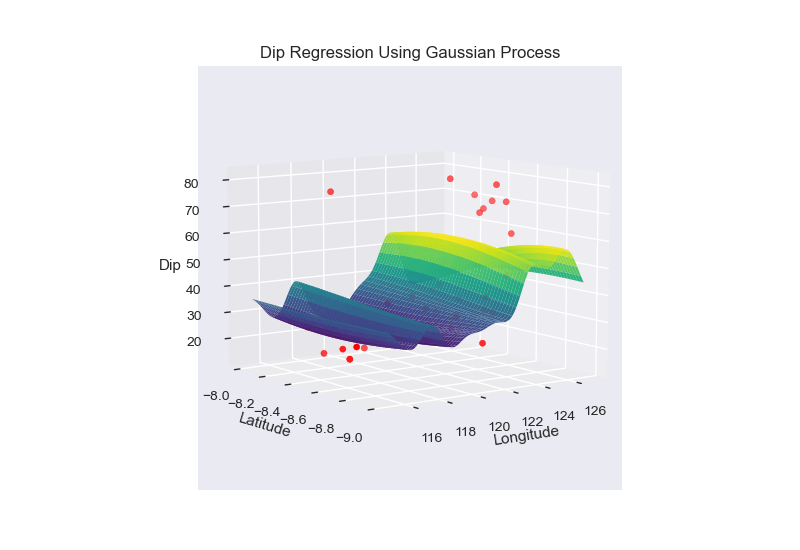

In [26]:
# Get data for fitting the GP
X = np.vstack([lats, lons]).T
y = dips.copy()
ker = lambda x,y: GPR.rbf_kernel(x,y,sig=0.75)
dip_gpr = GPR(kernel=ker, noise_level=1)

# Fit to data using Maximum Likelihood Estimation of the parameters
dip_gpr.fit(X, y)
Zplot = dip_gpr.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T, return_std=False)
Zplot = Zplot.reshape(Xplot.shape)
#sigma = sigma.reshape(Xplot.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='viridis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Dip')
plt.title('Dip Regression Using Gaussian Process')
plt.show()

<IPython.core.display.Javascript object>


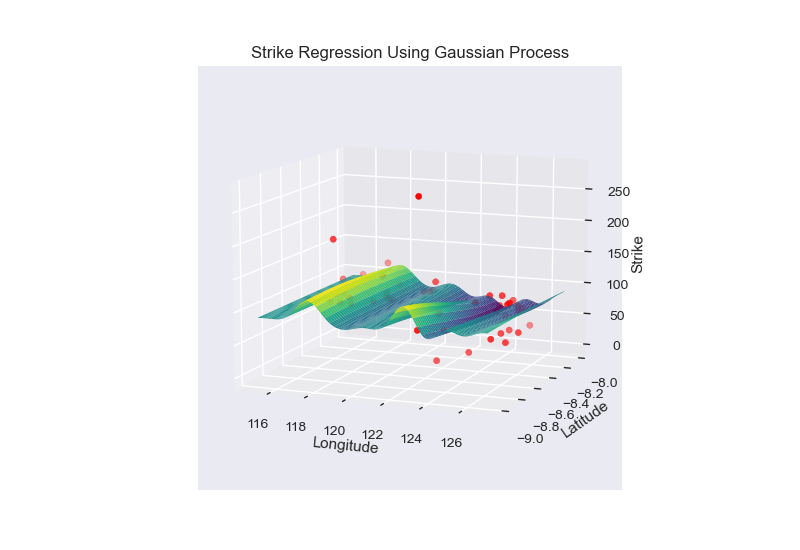

In [27]:
# Get data for fitting the GP
X = np.vstack([lats, lons]).T
y = strikes.copy()
ker = lambda x,y: GPR.rbf_kernel(x,y,sig=0.75)
strike_gpr = GPR(kernel=ker, noise_level=1)

# Fit to data using Maximum Likelihood Estimation of the parameters
strike_gpr.fit(X, y)
Zplot = strike_gpr.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T, return_std=False)
Zplot = Zplot.reshape(Xplot.shape)
#sigma = sigma.reshape(Xplot.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='viridis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Strike')
plt.title('Strike Regression Using Gaussian Process')
plt.show()

In [17]:
gpr = multid_GPR([depth_gpr, dip_gpr, strike_gpr])
Xtest = np.vstack([Yplot.flatten(), Xplot.flatten()]).T
preds = gpr.predict(Xtest)